In [1]:
import json, torch
import lightning  as L
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from torch.nn import functional as F
import csv
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
from scipy.interpolate import interp1d
import random

/home/davidteng/anaconda3/envs/wsd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"Using GPU: {torch.cuda.is_available()}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Using GPU: True
cuda:0


#### load training data

In [3]:
train_data_paths = [f"../36_TrainingData/L{loc}_Train.csv" for loc in range(1, 17+1)]
add_ids = [2,4,7,8,9,10,12]
add_train_data_paths = [f"../36_TrainingData_Additional_V2/L{loc}_Train_2.csv" for loc in add_ids]

train_data_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list)))))

for csv_path in train_data_paths:
    with open(csv_path, 'r', encoding='utf-8') as csv_file:
        reader = csv.reader(csv_file)
        header = next(reader)  # 跳過標題列
        for row in reader:
            # 解析數據並存入字典
            loc = row[0]
            date = row[1][:10]
            month = date[5:7]
            day = date[8:10]
            time = row[1][11:16]
            hour = time[:2]
            minute = time[-2:]
            train_data_dict[int(loc)][int(month)][int(day)][int(hour)][int(minute)] = float(row[-1])
for csv_path in add_train_data_paths:
    with open(csv_path, 'r', encoding='utf-8') as csv_file:
        reader = csv.reader(csv_file)
        header = next(reader)  # 跳過標題列
        for row in reader:
            # 解析數據並存入字典
            loc = row[0]
            date = row[1][:10]
            month = date[5:7]
            day = date[8:10]
            time = row[1][11:16]
            hour = time[:2]
            minute = time[-2:]
            train_data_dict[int(loc)][int(month)][int(day)][int(hour)][int(minute)] = float(row[-1])
print((train_data_dict[1][1][1][17][1]))

0.02


#### load cwb data

In [4]:
from collections import defaultdict
import numpy as np
import csv
from scipy.interpolate import interp1d

# 定义月份和特征
months = ['01','02','03','04','05','06','07','08', '09', '10']
features = ['rain', 'raintime', 'solarpower', 'suntime', 'temp', 'uv']

# 初始化 cwb_data_dict，四层嵌套：特征 -> 月份 -> 天数 -> 时间索引
# 时间索引初始为小时（0-23），插值后为分钟（0-1439）
cwb_data_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(float))))

# 读取气象数据
for month in months:
    for feature in features:
        csv_path = f'../cwbdata/{month}/{feature}-{month}.csv'
        try:
            with open(csv_path, 'r', encoding='utf-8') as csv_file:
                reader = csv.reader(csv_file)
                for row in reader:
                    if row[0].isdigit():
                        day = int(row[0])
                        for hour_index, value in enumerate(row[1:], start=0):
                            if hour_index < 24:
                                try:
                                    cwb_data_dict[feature][int(month)][day][hour_index] = float(value)
                                except (ValueError, TypeError):
                                    cwb_data_dict[feature][int(month)][day][hour_index] = None  # 标记为无效值
        except FileNotFoundError:
            print(f"文件未找到: {csv_path}")

# 初始化插值后的数据字典
cwb_data_interp_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))

def interpolate_minute_data(hourly_values):
    """
    对一天的24小时数据进行每分钟插值，返回1440分钟的浮点数列表。
    使用三次样条插值，并确保插值后的值不为负。
    """
    # 已知的分钟位置（每小时的第30分钟）
    known_minutes = np.array([h * 60 + 30 for h in range(24)])
    known_values = np.array(hourly_values)
    
    # 创建所有分钟的索引
    all_minutes = np.arange(1440)
    
    # 处理缺失值后进行插值
    # 使用三次样条插值
    try:
        # 创建插值函数
        spline = interp1d(known_minutes, known_values, kind='cubic', fill_value="extrapolate")
        interpolated = spline(all_minutes)
    except Exception as e:
        print(f"插值失败: {e}")
        interpolated = np.zeros(1440)
    
    # 确保插值后的值不为负
    interpolated = np.clip(interpolated, a_min=0, a_max=None)
    
    return interpolated.tolist()

# 处理每个特征、每个月、每天的数据
for feature in features:
    for month in range(1, 11):  # months '01' to '10' correspond to 1 to 10
        for day in cwb_data_dict[feature][month]:
            # 获取24小时的值
            hourly_values = [cwb_data_dict[feature][month][day].get(hour, None) for hour in range(24)]
            
            # 填充 None 值
            for hour in range(24):
                if hourly_values[hour] is None:
                    # 查找前一个有效值
                    prev = None
                    for h in range(hour - 1, -1, -1):
                        if hourly_values[h] is not None:
                            prev = hourly_values[h]
                            break
                    # 查找后一个有效值
                    next_val = None
                    for h in range(hour + 1, 24):
                        if hourly_values[h] is not None:
                            next_val = hourly_values[h]
                            break
                    # 计算平均值
                    if prev is not None and next_val is not None:
                        hourly_values[hour] = (prev + next_val) / 2
                    elif prev is not None:
                        hourly_values[hour] = prev
                    elif next_val is not None:
                        hourly_values[hour] = next_val
                    else:
                        hourly_values[hour] = 0.0  # 无有效值，填充0.0
            
            # 进行插值
            interpolated_minutes = interpolate_minute_data(hourly_values)
            
            # 将1440分钟的数据分成24个小时，每小时60分钟
            for hour in range(24):
                start_min = hour * 60
                end_min = start_min + 60
                cwb_data_interp_dict[feature][month][day][hour] = interpolated_minutes[start_min:end_min]
                # cwb_data_interp_dict[feature][month][day][hour] = [cwb_data_dict[feature][month][day][hour]] * 60

# 确保插值后的数据没有 None
for feature in features:
    for month in range(1, 11):
        for day in cwb_data_interp_dict[feature][month]:
            for hour in range(24):
                minute_data = cwb_data_interp_dict[feature][month][day][hour]
                if any([x is None for x in minute_data]):
                    # 进一步处理可能的 None（理论上已处理完毕）
                    cwb_data_interp_dict[feature][month][day][hour] = [0.0 if x is None else x for x in minute_data]

# 打印一个示例
print(cwb_data_dict['suntime'][1][1][1])  # 1月1日的1点的rain数据，60个浮点数
print(cwb_data_interp_dict['suntime'][1][2][11])  # 1月1日的1点的rain数据，60个浮点数


None
[1.0030271917571303, 1.002980498632662, 1.0029273676005712, 1.002868087846028, 1.002802948554203, 1.0027322389102673, 1.0026562480993912, 1.0025752653067452, 1.0024895797175004, 1.0023994805168275, 1.0023052568898967, 1.002207198021879, 1.0021055930979448, 1.0020007313032653, 1.0018929018230105, 1.0017823938423516, 1.001669496546459, 1.0015544991205034, 1.0014376907496556, 1.001319360619086, 1.0011997979139653, 1.0010792918194642, 1.0009581315207536, 1.0008366062030039, 1.000715005051386, 1.00059361725107, 1.0004727319872275, 1.0003526384450283, 1.0002336258096438, 1.0001159832662438, 0.9999999999999999, 0.9998859327217098, 0.9997739082446844, 0.999664020907861, 0.9995563650501782, 0.9994510350105738, 0.9993481251279862, 0.9992477297413528, 0.9991499431896118, 0.9990548598117015, 0.9989625739465601, 0.998873179933125, 0.9987867721103345, 0.9987034448171268, 0.99862329239244, 0.9985464091752118, 0.9984728895043804, 0.9984028277188841, 0.9983363181576603, 0.9982734551596478, 0.99821

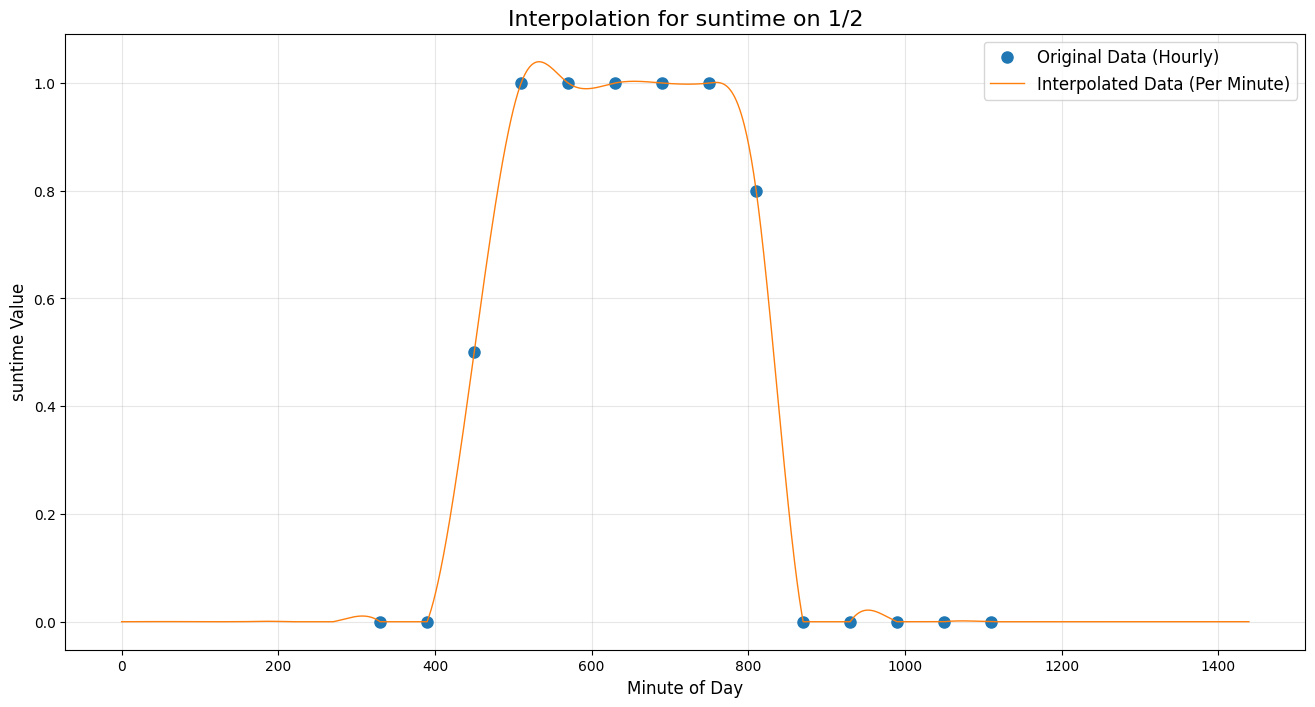

In [5]:
import matplotlib.pyplot as plt

# 选择一个示例日期和特征
sample_feature = 'suntime'  # 特征名称
sample_month = 1         # 月份
sample_day = 2           # 日期

# 获取原始小时值（0:30到23:30的值）
original_hours = [h * 60 + 30 for h in range(24)]
original_values = [cwb_data_dict[sample_feature][sample_month][sample_day].get(h, None) for h in range(24)]

# 获取插值后的分钟值
interpolated_minutes = []
for hour in range(24):
    interpolated_minutes.extend(cwb_data_interp_dict[sample_feature][sample_month][sample_day][hour])

# 创建分钟时间轴
minutes = np.arange(1440)

# 绘制插值结果
plt.figure(figsize=(16, 8))
plt.plot(original_hours, original_values, 'o', label='Original Data (Hourly)', markersize=8)
plt.plot(minutes, interpolated_minutes, '-', label='Interpolated Data (Per Minute)', linewidth=1)
plt.title(f'Interpolation for {sample_feature} on {sample_month}/{sample_day}', fontsize=16)
plt.xlabel('Minute of Day', fontsize=12)
plt.ylabel(f'{sample_feature} Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


#### preprocess data

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
import torch
from torch.utils.data import Dataset

class Cwb2LocDataset(Dataset):
    def __init__(self, train_data_dict, cwb_data_interp_dict, features, num_locs):
        self.x = []  # 存储连续特征
        self.loc = []  # 存储 loc 编码
        self.y = []  # 存储目标值

        # 初始化 One-Hot 编码器
        self.loc_encoder = OneHotEncoder(categories=[list(range(1, num_locs + 1))], sparse_output=False)
        self.loc_encoder.fit(np.array(range(1, num_locs + 1)).reshape(-1, 1))

        def extract_features(cwb_data_interp_dict, features, location, month, day, hour, minute):
            try:
                newx = [cwb_data_interp_dict[feature][month][day][hour][minute] for feature in features]
            except Exception as e:
                print(f"Error at {location}-{month}-{day} {hour}:{minute}: {e}")
                newx = [0.0] * len(features)
            return newx

        # 构造特征
        for location in train_data_dict:
            for month in train_data_dict[location]:
                for day in train_data_dict[location][month]:
                    for hour in train_data_dict[location][month][day]:
                        for minute in train_data_dict[location][month][day][hour]:
                            # 提取连续特征
                            continuous_features = []
                            for min_offset in range(minute - 2, minute + 3):
                                if 0 <= min_offset <= 59:
                                    continuous_features += extract_features(cwb_data_interp_dict, features, location, month, day, hour, min_offset)
                                elif min_offset < 0:
                                    try:
                                        continuous_features += extract_features(cwb_data_interp_dict, features, location, month, day, hour - 1, min_offset + 60)
                                    except Exception as e:
                                        continuous_features += [0.0] * len(features)
                                elif min_offset > 59:
                                    try:
                                        continuous_features += extract_features(cwb_data_interp_dict, features, location, month, day, hour + 1, min_offset - 60)
                                    except Exception as e:
                                        continuous_features += [0.0] * len(features)
                            
                            # 如果特征数量正确
                            if len(continuous_features) == len(features) * 5:
                                self.x.append(continuous_features)
                                self.loc.append(location)
                                self.y.append(train_data_dict[location][month][day][hour][minute])
        
        # 转为 NumPy 数组
        self.x = np.array(self.x, dtype=np.float32)
        self.loc = np.array(self.loc).reshape(-1, 1)
        self.y = np.array(self.y, dtype=np.float32).reshape(-1, 1)

        # One-Hot 编码 loc
        self.loc = self.loc_encoder.transform(self.loc)

        # 标准化连续特征和目标
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        self.x = self.x_scaler.fit_transform(self.x)
        self.y = self.y_scaler.fit_transform(self.y)

        # 保存标准化器和编码器
        with open(f'./scalar_v4/x_scaler-{ID}.pkl', 'wb') as f:
            pickle.dump(self.x_scaler, f)
        with open(f'./scalar_v4/y_scaler-{ID}.pkl', 'wb') as f:
            pickle.dump(self.y_scaler, f)
        with open(f'./scalar_v4/loc_encoder-{ID}.pkl', 'wb') as f:
            pickle.dump(self.loc_encoder, f)

    def __getitem__(self, index):
        # 将连续特征和 loc 编码合并为一个张量
        x_combined = np.concatenate([self.x[index], self.loc[index]])
        return torch.tensor(x_combined, dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

    def __len__(self):
        return len(self.x)


In [7]:
# test = Cwb2LocDataset(
#     train_data_dict,
#     cwb_data_interp_dict,
#     features=features,
#     num_locs=17
# )
# print((test[0]))

#### cut data

In [8]:
class Cwb2LocDataModule(L.LightningDataModule):
    def __init__(self, train_data_dict, cwb_data_dict, features, batch_size=16, loc = 17, train_split=0.9):
        super().__init__()
        self.train_data_dict = train_data_dict
        self.cwb_data_dict = cwb_data_dict
        self.batch_size = batch_size
        self.train_split = train_split
        self.features = features
        self.locnum = loc

    def setup(self, stage=None):
        dataset = Cwb2LocDataset(self.train_data_dict, self.cwb_data_dict, self.features, self.locnum)
        train_size = int(len(dataset) * self.train_split)
        val_size = len(dataset) - train_size
        
        # 设置随机种子
        torch.manual_seed(42)  # 确保 PyTorch 随机性可重复
        random.seed(42)        # 确保 Python 随机性可重复
        np.random.seed(42)     # 确保 NumPy 随机性可重复
        
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

In [9]:
# test_datamodule = Cwb2LocDataModule(train_data_dict, cwb_data_interp_dict, features)
# test_datamodule.setup()
# train_loader = test_datamodule.train_dataloader()
# val_loader = test_datamodule.val_dataloader()

# print(f"Train batches: {len(train_loader)}")
# print(f"Validation batches: {len(val_loader)}")

# # 測試加載數據
# for batch in train_loader:
#     x, y = batch
#     print(f"Train batch features shape: {x.shape}")
#     print(f"Train batch labels shape: {y.shape}")
#     break

# for batch in val_loader:
#     x, y = batch
#     print(f"Validation batch features shape: {x.shape}")
#     print(f"Validation batch labels shape: {y.shape}")
#     break

In [10]:
class Cwb2LocModel(L.LightningModule):
    def __init__(self, input_dim=47, hidden_dim=128, output_dim=1, learning_rate=1e-3):
        """
        MLP 模型
        - input_dim: 输入特征的维度
        - hidden_dim: 隐藏层神经元数量
        - output_dim: 输出维度（目标维度）
        - learning_rate: 学习率
        """
        super(Cwb2LocModel, self).__init__()
        self.save_hyperparameters()

        # 定义全连接层
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

        # 激活函数
        self.relu = nn.ReLU()

        # 损失函数
        self.criterion = nn.L1Loss()  # 可以改为 MSELoss 或其他损失函数

    def forward(self, x):
        # 前向传播
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,  # 初始学习率
            weight_decay=1e-2               # 权重衰减
        )
        
        # 学习率调度器
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            threshold=1e-4,
            cooldown=3,
            min_lr=1e-6,
            verbose=True
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "frequency": 1
            }
        }


In [11]:
batch_size = 256
learning_rate=1e-3
# loc = 2
hidden_dim = 128
ID = 'A'
data_module = Cwb2LocDataModule(train_data_dict, cwb_data_interp_dict, features, batch_size)
model = Cwb2LocModel(
    input_dim=47,
    hidden_dim=hidden_dim,
    output_dim=1,
    learning_rate=learning_rate
)
wandb_name = f'{ID}-f6*5_loc-one-hot_b{batch_size}_h{hidden_dim}_lr{learning_rate}_mae_p32_3fc_指數插值_RELU'
# dirpath=f'./saved_models/{loc}/{wandb_name}'
# dirpath=f'./saved_models/{loc}'
dirpath=f'./saved_models_v4'

In [12]:
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
logger = WandbLogger(
    project='aicup_power_v4', 
    name=wandb_name,
    save_dir=None,
    offline=False,
    log_model=False,  # 不保存模型
    save_code=False   # 不保存代碼快照
)
callbacks = [
    LearningRateMonitor(),
    ModelCheckpoint(
        monitor='val_loss',
        mode='min',
        auto_insert_metric_name=False,
        dirpath=dirpath,
        filename=f'best-checkpoint-{ID}',
        save_top_k=1,
    ),
    EarlyStopping(
        monitor='val_loss',   # 監控的指標
        patience=100,           # 如果 3 個 epoch 驗證損失沒有改善，則停止訓練
        verbose=True,
        mode='min'            # 損失越小越好
    )
]

In [13]:
trainer = L.Trainer(
    precision=32,
    gradient_clip_val=1.0,
    accumulate_grad_batches=1,
    max_epochs=10000,
    val_check_interval=1.0,
    logger=logger,
    callbacks=callbacks,
    enable_progress_bar=True
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [ ]:
trainer.fit(model, datamodule=data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: david___teng (david___teng-national-central-university). Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/davidteng/anaconda3/envs/wsd/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type   | Params | Mode 
---------------------------------------------
0 | fc1       | Linear | 6.1 K  | train
1 | fc2       | Linear | 8.3 K  | train
2 | fc3       | Linear | 65     | train
3 | relu      | ReLU   | 0      | train
4 | criterion | L1Loss | 0      | train
---------------------------------------------
14.5 K    Trainable params
0         Non-trainable params
14.5 K    Total params
0.058     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


/home/davidteng/anaconda3/envs/wsd/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/davidteng/anaconda3/envs/wsd/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 4829/4829 [00:57<00:00, 84.22it/s, v_num=2aqh, train_loss_step=0.296, val_loss=0.255, train_loss_epoch=0.269]

Metric val_loss improved. New best score: 0.255


Epoch 1: 100%|██████████| 4829/4829 [01:00<00:00, 79.80it/s, v_num=2aqh, train_loss_step=0.203, val_loss=0.238, train_loss_epoch=0.240]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.238


Epoch 2: 100%|██████████| 4829/4829 [00:57<00:00, 84.33it/s, v_num=2aqh, train_loss_step=0.205, val_loss=0.220, train_loss_epoch=0.226]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.220


Epoch 3: 100%|██████████| 4829/4829 [00:55<00:00, 86.59it/s, v_num=2aqh, train_loss_step=0.059, val_loss=0.215, train_loss_epoch=0.217] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.215


Epoch 4: 100%|██████████| 4829/4829 [00:55<00:00, 87.04it/s, v_num=2aqh, train_loss_step=0.214, val_loss=0.210, train_loss_epoch=0.212]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.210


Epoch 5: 100%|██████████| 4829/4829 [00:55<00:00, 86.40it/s, v_num=2aqh, train_loss_step=0.0561, val_loss=0.207, train_loss_epoch=0.209]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.207


Epoch 6: 100%|██████████| 4829/4829 [00:58<00:00, 82.97it/s, v_num=2aqh, train_loss_step=0.348, val_loss=0.205, train_loss_epoch=0.205] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.205


Epoch 9: 100%|██████████| 4829/4829 [00:55<00:00, 86.61it/s, v_num=2aqh, train_loss_step=0.0927, val_loss=0.196, train_loss_epoch=0.198]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.196


Epoch 11: 100%|██████████| 4829/4829 [00:58<00:00, 83.21it/s, v_num=2aqh, train_loss_step=0.271, val_loss=0.191, train_loss_epoch=0.196]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.191


Epoch 13: 100%|██████████| 4829/4829 [00:59<00:00, 80.95it/s, v_num=2aqh, train_loss_step=0.479, val_loss=0.190, train_loss_epoch=0.194] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.190


Epoch 16: 100%|██████████| 4829/4829 [00:56<00:00, 85.75it/s, v_num=2aqh, train_loss_step=0.301, val_loss=0.189, train_loss_epoch=0.191] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.189


Epoch 18: 100%|██████████| 4829/4829 [00:57<00:00, 84.57it/s, v_num=2aqh, train_loss_step=0.165, val_loss=0.186, train_loss_epoch=0.190]  

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.186


Epoch 22: 100%|██████████| 4829/4829 [00:52<00:00, 92.33it/s, v_num=2aqh, train_loss_step=0.230, val_loss=0.178, train_loss_epoch=0.179]  

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.178


Epoch 23: 100%|██████████| 4829/4829 [00:58<00:00, 83.17it/s, v_num=2aqh, train_loss_step=0.0764, val_loss=0.176, train_loss_epoch=0.178]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.176


Epoch 29: 100%|██████████| 4829/4829 [00:56<00:00, 84.97it/s, v_num=2aqh, train_loss_step=0.190, val_loss=0.174, train_loss_epoch=0.171]  

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.174


Epoch 30: 100%|██████████| 4829/4829 [00:56<00:00, 84.81it/s, v_num=2aqh, train_loss_step=0.379, val_loss=0.173, train_loss_epoch=0.170] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.173


Epoch 31: 100%|██████████| 4829/4829 [00:52<00:00, 91.87it/s, v_num=2aqh, train_loss_step=0.346, val_loss=0.170, train_loss_epoch=0.170]  

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.170


Epoch 35: 100%|██████████| 4829/4829 [00:56<00:00, 85.56it/s, v_num=2aqh, train_loss_step=0.199, val_loss=0.168, train_loss_epoch=0.166] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.168


Epoch 36: 100%|██████████| 4829/4829 [00:54<00:00, 88.06it/s, v_num=2aqh, train_loss_step=0.166, val_loss=0.168, train_loss_epoch=0.166] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.168


Epoch 38: 100%|██████████| 4829/4829 [00:58<00:00, 82.12it/s, v_num=2aqh, train_loss_step=0.107, val_loss=0.167, train_loss_epoch=0.166] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.167


Epoch 40:  29%|██▉       | 1406/4829 [00:15<00:37, 90.88it/s, v_num=2aqh, train_loss_step=0.183, val_loss=0.168, train_loss_epoch=0.165] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

: 